In [17]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

Raster loaded: Urban_Growth_1990_2005.tif
Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2698, 'height': 2057, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'), 'transform': Affine(30.0, 0.0, 299580.0,
       0.0, -30.0, 571350.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


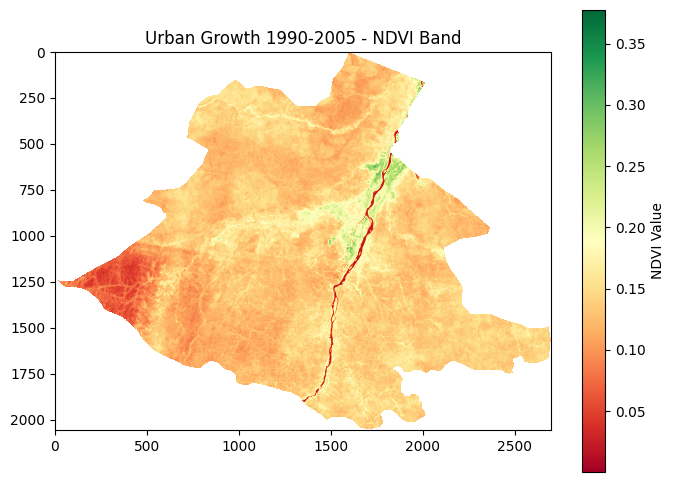

Raster loaded: Urban_Growth_2005_2020.tif
Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2698, 'height': 2057, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'), 'transform': Affine(30.0, 0.0, 299580.0,
       0.0, -30.0, 571350.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


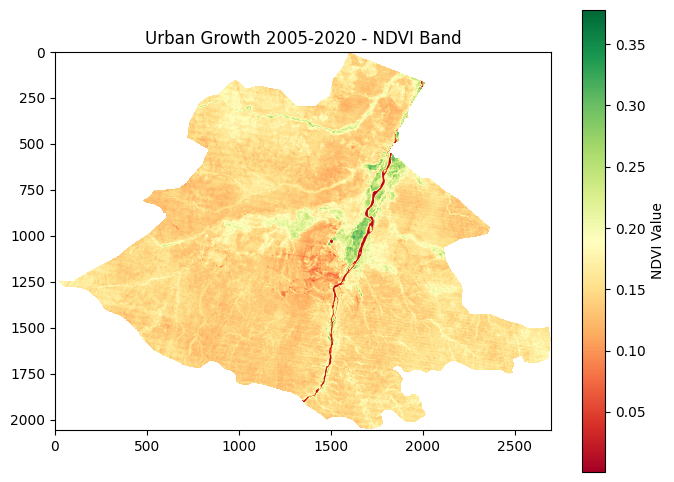

In [19]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define file paths (update with your actual file locations)
urban_1990_2005_path = "Urban_Growth_1990_2005.tif"
urban_2005_2020_path = "Urban_Growth_2005_2020.tif"

# Function to read raster data and visualize it
def read_and_visualize_raster(file_path, title):
    with rasterio.open(file_path) as src:
        data = src.read()
        profile = src.profile  # Get metadata

        print(f"Raster loaded: {file_path}")
        print(f"Metadata: {profile}")

        # Visualize NDVI band (first band as an example)
        plt.figure(figsize=(8, 6))
        plt.imshow(data[0], cmap='RdYlGn')
        plt.title(f'{title} - NDVI Band')
        plt.colorbar(label='NDVI Value')
        plt.show()
    
    return data, profile

# Load and visualize the data
urban_1990_2005, profile_1990_2005 = read_and_visualize_raster(urban_1990_2005_path, "Urban Growth 1990-2005")
urban_2005_2020, profile_2005_2020 = read_and_visualize_raster(urban_2005_2020_path, "Urban Growth 2005-2020")


In [20]:
# Function to reshape raster data to 2D array for ML
def reshape_raster_to_features(raster_data):
    bands, rows, cols = raster_data.shape
    reshaped_data = raster_data.reshape(bands, rows * cols).T  # Transpose to (pixels, bands)
    return reshaped_data

# Reshape the raster data for ML
X_1990_2005 = reshape_raster_to_features(urban_1990_2005)
X_2005_2020 = reshape_raster_to_features(urban_2005_2020)

# Remove NaN values (if any)
mask = ~np.isnan(X_1990_2005).any(axis=1) & ~np.isnan(X_2005_2020).any(axis=1)
X_1990_2005 = X_1990_2005[mask]
X_2005_2020 = X_2005_2020[mask]

# Generate binary labels (1 = urban growth, 0 = no change)
y = np.where(X_2005_2020[:, 0] > X_1990_2005[:, 0], 1, 0)  # Growth based on NDVI increase

print("Feature data shape:", X_1990_2005.shape)
print("Label data shape:", y.shape)


Feature data shape: (2793803, 3)
Label data shape: (2793803,)


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1990_2005, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model Accuracy: 0.7960772710081001
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.34      0.42    179871
           1       0.84      0.92      0.88    658270

    accuracy                           0.80    838141
   macro avg       0.69      0.63      0.65    838141
weighted avg       0.77      0.80      0.78    838141

Confusion Matrix:
 [[ 60688 119183]
 [ 51733 606537]]


In [23]:
# Predict future urban growth for 2020-2030 based on the 2005-2020 data
future_growth_prediction = rf_model.predict(X_2005_2020)

# Ensure predictions match the number of pixels
total_pixels = urban_2005_2020.shape[1] * urban_2005_2020.shape[2]
if future_growth_prediction.size != total_pixels:
    raise ValueError(f"Number of predictions ({future_growth_prediction.size}) does not match number of pixels ({total_pixels}).")

# Reshape predictions back to raster format
future_growth_raster = future_growth_prediction.reshape(
    urban_2005_2020.shape[1], urban_2005_2020.shape[2])

# Save the predicted growth raster as a GeoTIFF
output_path = "Urban_Growth_Prediction_2020_2030.tif"
with rasterio.open(
    output_path, 'w', **profile_2005_2020) as dst:
    dst.write(future_growth_raster, 1)

print(f"Future urban growth prediction saved to {output_path}")


ValueError: Number of predictions (2793803) does not match number of pixels (5549786).

In [ ]:
# Visualize the predicted urban growth
plt.figure(figsize=(8, 6))
plt.imshow(future_growth_raster, cmap='coolwarm')
plt.title('Predicted Urban Growth (2020-2030)')
plt.colorbar(label="Urban Growth Prediction")
plt.show()

In [ ]:
import pandas as pd

# Export predictions to CSV for further analysis
df_results = pd.DataFrame(future_growth_prediction, columns=["Urban_Growth_Prediction"])
df_results.to_csv("Urban_Growth_Prediction_2020_2030.csv", index=False)

print("Predicted urban growth data exported to CSV.")


Raster loaded: Urban_Growth_1990_2005.tif
Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2698, 'height': 2057, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'), 'transform': Affine(30.0, 0.0, 299580.0,
       0.0, -30.0, 571350.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


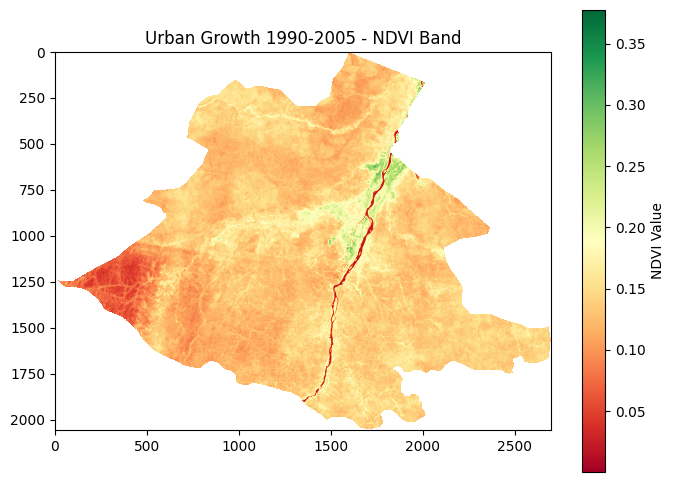

Raster loaded: Urban_Growth_2005_2020.tif
Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2698, 'height': 2057, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'), 'transform': Affine(30.0, 0.0, 299580.0,
       0.0, -30.0, 571350.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


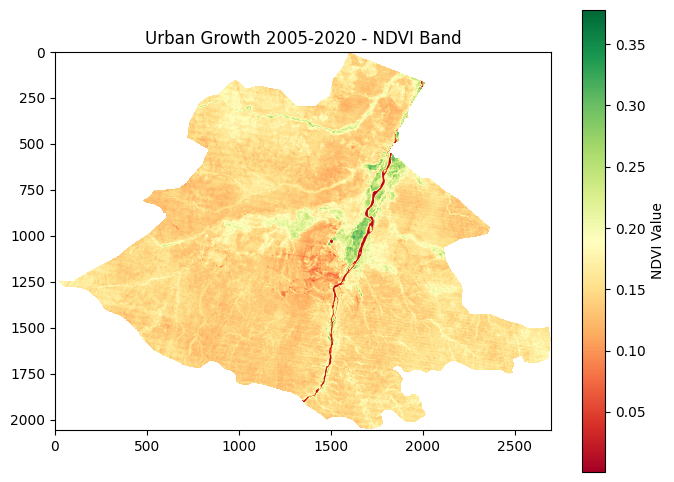

Urban 1990-2005 raster dimensions: (3, 2057, 2698)
Urban 2005-2020 raster dimensions: (3, 2057, 2698)
Expected total pixels from urban_2005_2020: 5549786
Feature matrix shape (X_2005_2020): (5549786, 3)
Initial NaN values in X_1990_2005: [2755983 2755983 2755983]
Initial NaN values in X_2005_2020: [2755983 2755983 2755983]
Number of valid data points after masking: 2793803
Model Accuracy: 0.7960772710081001
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.34      0.42    179871
           1       0.84      0.92      0.88    658270

    accuracy                           0.80    838141
   macro avg       0.69      0.63      0.65    838141
weighted avg       0.77      0.80      0.78    838141

Confusion Matrix:
 [[ 60688 119183]
 [ 51733 606537]]
Mismatch between predicted size and total pixels. Consider adjusting the masking or handling NaN values more flexibly.


ValueError: cannot reshape array of size 2793803 into shape (2057,2698)

In [31]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Define file paths (update with your actual file locations)
urban_1990_2005_path = "Urban_Growth_1990_2005.tif"
urban_2005_2020_path = "Urban_Growth_2005_2020.tif"

# Function to read raster data and visualize it
def read_and_visualize_raster(file_path, title):
    with rasterio.open(file_path) as src:
        data = src.read()
        profile = src.profile  # Get metadata

        print(f"Raster loaded: {file_path}")
        print(f"Metadata: {profile}")

        # Visualize NDVI band (first band as an example)
        plt.figure(figsize=(8, 6))
        plt.imshow(data[0], cmap='RdYlGn')
        plt.title(f'{title} - NDVI Band')
        plt.colorbar(label='NDVI Value')
        plt.show()
    
    return data, profile

# Load and visualize the data
urban_1990_2005, profile_1990_2005 = read_and_visualize_raster(urban_1990_2005_path, "Urban Growth 1990-2005")
urban_2005_2020, profile_2005_2020 = read_and_visualize_raster(urban_2005_2020_path, "Urban Growth 2005-2020")

# Print raster dimensions
print("Urban 1990-2005 raster dimensions:", urban_1990_2005.shape)
print("Urban 2005-2020 raster dimensions:", urban_2005_2020.shape)

# Function to reshape raster data to 2D array for ML
def reshape_raster_to_features(raster_data):
    bands, rows, cols = raster_data.shape
    reshaped_data = raster_data.reshape(bands, rows * cols).T  # Transpose to (pixels, bands)
    return reshaped_data

# Reshape the raster data for ML
X_1990_2005 = reshape_raster_to_features(urban_1990_2005)
X_2005_2020 = reshape_raster_to_features(urban_2005_2020)

# Check if the number of rows matches the expected total pixels
expected_pixels = urban_2005_2020.shape[1] * urban_2005_2020.shape[2]
print("Expected total pixels from urban_2005_2020:", expected_pixels)
print("Feature matrix shape (X_2005_2020):", X_2005_2020.shape)

# Print initial NaN values
print("Initial NaN values in X_1990_2005:", np.isnan(X_1990_2005).sum(axis=0))
print("Initial NaN values in X_2005_2020:", np.isnan(X_2005_2020).sum(axis=0))

# Remove NaN values (if any)
mask = ~np.isnan(X_1990_2005).any(axis=1) & ~np.isnan(X_2005_2020).any(axis=1)
X_1990_2005 = X_1990_2005[mask]
X_2005_2020 = X_2005_2020[mask]

# Check the number of rows after masking
print("Number of valid data points after masking:", X_2005_2020.shape[0])

# Generate binary labels (1 = urban growth, 0 = no change)
y = np.where(X_2005_2020[:, 0] > X_1990_2005[:, 0], 1, 0)  # Growth based on NDVI increase

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1990_2005, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Predict future urban growth for 2020-2030 based on the 2005-2020 data
future_growth_prediction = rf_model.predict(X_2005_2020)

# Ensure predictions match the number of pixels
if future_growth_prediction.size != expected_pixels:
    print("Mismatch between predicted size and total pixels. Consider adjusting the masking or handling NaN values more flexibly.")

# Reshape predictions back to raster format
future_growth_raster = future_growth_prediction.reshape(
    urban_2005_2020.shape[1], urban_2005_2020.shape[2])

# Save the predicted growth raster as a GeoTIFF
output_path = "Urban_Growth_Prediction_2020_2030.tif"
with rasterio.open(
    output_path, 'w', **profile_2005_2020) as dst:
    dst.write(future_growth_raster, 1)

print(f"Future urban growth prediction saved to {output_path}")

# Visualize the predicted urban growth
plt.figure(figsize=(8, 6))
plt.imshow(future_growth_raster, cmap='coolwarm')
plt.title('Predicted Urban Growth (2020-2030)')
plt.colorbar(label="Urban Growth Prediction")
plt.show()

# Export predictions to CSV for further analysis
df_results = pd.DataFrame(future_growth_prediction, columns=["Urban_Growth_Prediction"])
df_results.to_csv("Urban_Growth_Prediction_2020_2030.csv", index=False)

print("Predicted urban growth data exported to CSV.")
